In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd

tfd = tfp.distributions 

from core.run import prior_elicitation
from user.generative_models import ToyModel
from user.custom_functions import Normal_log
from core.write_results import create_output_summary

C:\Users\bockting\AppData\Local\anaconda3\envs\elicitation-env\Lib\site-packages\bayesflow\trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### The model
The statistical model of the toy example is an intercept-only normal model with location $\mu$ and random noise $\sigma$. The location parameter $\mu$ is a function of the intercept $\beta_0$.    
$$
\begin{align*}
    \beta_0 &\sim \text{Normal}(\mu_\mu, \sigma_\mu)\quad \quad &\text{Priors}\\
    \sigma &\sim \text{Normal}(0, \sigma_\sigma)\quad \quad &\\
    \mu &= \textbf{1}_N\beta_0 \quad \quad &\text{with obs}=1,\ldots, N\\
    height_i &\sim \text{Normal}(\mu, \sigma) \quad \quad &\text{Likelihood}
\end{align*}
$$
Our goal is to find values for $\lambda = (\mu_\mu, \sigma_\mu, \sigma_\sigma)$.

In [2]:
# implementation of the generative model
??ToyModel

Init signature: ToyModel()
Docstring:      <no docstring>
Source:        
class ToyModel:
    def __call__(self, ground_truth, prior_samples, N):
        # number of observations (intercept-only)
        X = tf.ones((1,N))
        # linear predictor (= mu)
        epred = tf.expand_dims(prior_samples[:,:,0],-1) @ X
        # data-generating model 
        likelihood = tfd.Normal(loc=epred,
                                scale=tf.expand_dims(prior_samples[:,:,1],-1))
        # prior predictive distribution (=height)
        ypred = likelihood.sample()
        
        return dict(likelihood = likelihood,     
                    ypred = ypred,                 
                    epred = epred,
                    prior_samples = prior_samples                 
                    )
File:           c:\users\bockting\documents\github\prior_elicitation\elicit\user\generative_models.py
Type:           type
Subclasses:     

## Expert information
**Example elicitation approach:**

The expert is asked w.r.t.
+ their *median* ($Q_{50}$; value for which there is a 50/50 chance of being more or less)
+ the lower and upper quartiles ($Q_{25}$ and $Q_{75}$ respectively; the expert should judge it to be equally likely for $y$ to be below $Q_{25}$ or between $Q_{25}$ and $Q_{50}$, and they should also judge it equally likely that $y$ would be between $Q_{50}$ and $Q_{75}$ or above $Q_{75}$.)
+ the lower and upper boundary ($Q_{5}$ and $Q_{95}$ respectively; equivalent to min and max but more stable)
+ a coherence check: $Q_{5} < Q_{25} < Q_{50} < Q_{75} < Q_{95}$ (ranking should not be violated)


In [3]:
expert_info = pd.read_pickle("../../../elicit/simulations/parametric_prior_examples/expert_data/toy-example/elicited_statistics.pkl")

expert_data = pd.DataFrame(
    tf.round(expert_info["quantiles_ypred"]), 
    columns=[fr"$Q_{{{i}}}$" for i in [5,25,50,75,95]], 
    index = ["true"]
)

expert_data

,$Q_{5}$,$Q_{25}$,$Q_{50}$,$Q_{75}$,$Q_{95}$
true,154.0,166.0,170.0,174.0,186.0


In [2]:
normal_log = Normal_log()

prior_elicitation(
    model_parameters=dict(
        mu=dict(family=normal_log, 
                hyperparams_dict={
                      "mu_loc": tfd.Uniform(100.,200.),
                      "log_mu_scale": tfd.Uniform(0., 5)
                      },
                param_scaling=1.
                ),
        sigma=dict(family=tfd.HalfNormal,
                   hyperparams_dict={
                      "sigma_scale": tfd.Uniform(1.,50.)
                      },
                   param_scaling=1.
                   ),
        independence = False
        ),
    expert_data=dict(
        #data=expert_info,
        from_ground_truth = True,
        simulator_specs = {
            "mu": tfd.Normal(loc=170, scale=2),
            "sigma": tfd.HalfNormal(scale=10.),
            },
        samples_from_prior = 10000
        ),
    generative_model=dict(
        model=ToyModel,
        additional_model_args={
            "N": 200
            }
        ),
    target_quantities=dict(
        ypred=dict(
            elicitation_method="quantiles",
            quantiles_specs=(5, 25, 50, 75, 95),
            loss_components = "all"
            )
        ),
    optimization_settings=dict(
        optimizer_specs={
            "learning_rate": 0.2, #tf.keras.optimizers.schedules.CosineDecay(
                #0.2, 700),
            "clipnorm": 1.0
            }
        ),
    loss_function=dict(
        use_regularization=True
    ),
    training_settings=dict(
        method="parametric_prior",
        sim_id="toy_example",
        warmup_initializations=1,
        seed=0,
        view_ep=70,
        epochs=700
    )
    )

| 
epoch_time: 0.662 sec
Epoch: 0, loss: 1.14521, lr: 0.200000
epoch_time: 0.426 sec
Epoch: 70, loss: -1.49377, lr: 0.200000
Estimated time until completion: 00:04:17
epoch_time: 0.409 sec
Epoch: 140, loss: -1.49086, lr: 0.200000
Estimated time until completion: 00:03:44


KeyboardInterrupt: 

## Results

### Loss function and convergence

In [23]:
pd.read_pickle("./elicit/results/parametric_prior/toy_example_0/elicited_statistics.pkl")["quantiles_ypred"]

<tf.Tensor: shape=(128, 5), dtype=float32, numpy=
array([[ 5.30556774e+00,  4.54802856e+01,  9.59316101e+01,
         1.68467224e+02,  2.72828583e+02],
       [ 8.09672546e+00,  5.66485443e+01,  1.12837029e+02,
         1.75816956e+02,  2.72732300e+02],
       [ 8.03468800e+00,  4.72069321e+01,  9.87339172e+01,
         1.59506989e+02,  2.62512482e+02],
       [ 4.39874840e+00,  4.27240372e+01,  9.12481308e+01,
         1.66258102e+02,  2.89337799e+02],
       [ 3.61901855e+00,  4.32457428e+01,  9.10071259e+01,
         1.54638565e+02,  2.55022003e+02],
       [ 3.56037903e+00,  3.64966087e+01,  7.96057434e+01,
         1.52207352e+02,  2.65504883e+02],
       [ 6.57787609e+00,  4.75957794e+01,  8.89431000e+01,
         1.49788773e+02,  2.79814850e+02],
       [ 2.46062088e+00,  3.58774300e+01,  8.48769760e+01,
         1.57146286e+02,  2.86680389e+02],
       [ 5.31820965e+00,  4.55970840e+01,  9.28739929e+01,
         1.60426910e+02,  2.84848053e+02],
       [ 3.61586642e+00,  3.9180

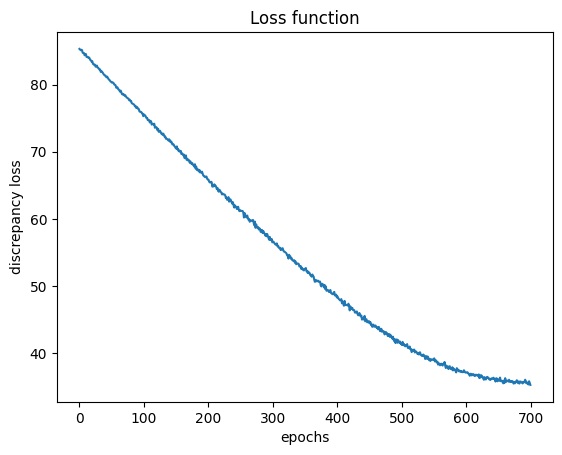

In [4]:
from plotting import func
path = "./elicit/results/parametric_prior/toy_example_0"

func.plot_loss(path)

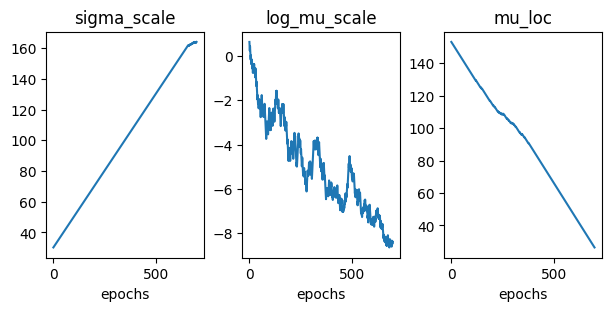

In [5]:
func.plot_convergence(path)

### Elicited statistics 

In [7]:
model_data = pd.DataFrame(
    tf.reduce_mean(pd.read_pickle(path+"/elicited_statistics.pkl")["quantiles_ypred"],0)[None,:],
    columns=[fr"$Q_{{{i}}}$" for i in [5,25,50,75,95]], 
    index=["model"])
model_data
#pd.concat([expert_data, model_data])

,$Q_{5}$,$Q_{25}$,$Q_{50}$,$Q_{75}$,$Q_{95}$
model,-0.220608,52.925869,112.025452,189.249146,321.288361


### Prior distributions

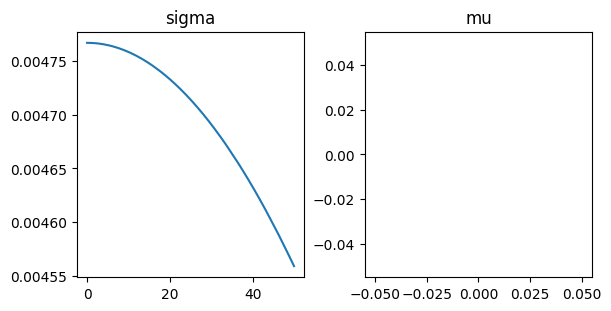

In [9]:
import matplotlib.pyplot as plt

hyp=pd.read_pickle(path+"/final_results.pkl")["hyperparameter"]
learned_hyp=tf.reduce_mean(tf.stack([hyp[k][-30:] for k in hyp],-1), 0)
gd = pd.read_pickle(path+"/global_dict.pkl")

xrge = tf.range(0.,50., 0.01)
xrge2 = tf.range(100.,200., 0.1)
sigma = gd["model_parameters"]["sigma"]["family"](learned_hyp[0]).prob(xrge)
mu = gd["model_parameters"]["mu"]["family"](learned_hyp[1], learned_hyp[2]).prob(xrge2)

_, axs = plt.subplots(1,2, constrained_layout=True, figsize=(6,3))
axs[0].plot(xrge, sigma)
axs[0].set_title("sigma")
axs[1].plot(xrge2, mu)
axs[1].set_title("mu")
plt.show()